In [1]:
import pandas as pd

# Load the data
data = data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/META_stock_data.csv") 

In [2]:
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-04-10 00:00:00-04:00,214.482434,215.431424,210.436723,214.522385,16106100,0.0,0.0
1,2023-04-11 00:00:00-04:00,215.251614,215.791050,213.183816,213.623352,16710100,0.0,0.0
2,2023-04-12 00:00:00-04:00,214.612284,216.610164,212.354685,213.773178,18972200,0.0,0.0
3,2023-04-13 00:00:00-04:00,215.501341,220.915595,215.461391,220.116455,23310400,0.0,0.0
4,2023-04-14 00:00:00-04:00,217.649075,221.874587,217.319423,221.255249,21591200,0.0,0.0


In [3]:
data['MA21'] = data['Close'].rolling(window=21).mean()

In [4]:
def calculate_rsi(data, window=21):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data['Close'])


In [5]:
data = data.dropna()  # Loại bỏ các hàng chứa giá trị NaN do tính RSI và MA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, 20 to 250
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          231 non-null    object 
 1   Open          231 non-null    float64
 2   High          231 non-null    float64
 3   Low           231 non-null    float64
 4   Close         231 non-null    float64
 5   Volume        231 non-null    int64  
 6   Dividends     231 non-null    float64
 7   Stock Splits  231 non-null    float64
 8   MA21          231 non-null    float64
 9   RSI           231 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 19.9+ KB


In [7]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size 
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
import warnings

# Tắt cảnh báo SettingWithCopyWarning
pd.options.mode.chained_assignment = None 
# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close', 'Open', 'High', 'Low','MA21','RSI']
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (184, 6)
Validation data shape: (23, 6)
Test data shape: (24, 6)


In [51]:
# Training data
seq_len = 21
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) 
  y_train.append(train_data[:, 0][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)


# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)


# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (474, 21, 6) (474,)
Validation set shape (40, 21, 6) (40,)
Testing set shape (42, 21, 6) (42,)


In [52]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Embedding, GlobalAveragePooling1D,Flatten, Add
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

In [53]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, embed_dim)
    
    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embed_dim))
        return pos * angle_rates
    
    def positional_encoding(self, max_len, embed_dim):
        angle_rads = self.get_angles(np.arange(max_len)[:, np.newaxis],
                                     np.arange(embed_dim)[np.newaxis, :],
                                     embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Thông số mô hình
embed_dim = 32  # Kích thước của embedding
num_heads = 4  # Số lượng đầu attention
ff_dim = 64  # Kích thước của feed forward layer
num_transformer_blocks = 3  # Số lượng Transformer blocks
max_len = 21  # Chiều dài tối đa của chuỗi đầu vào
num_features = 6  # Số lượng đặc trưng đầu vào

# Đầu vào của Transformer
inputs = Input(shape=(max_len, num_features))
x = Dense(embed_dim)(inputs)
x = PositionalEncoding(max_len, embed_dim)(x)

# Xây dựng các Transformer blocks
for _ in range(num_transformer_blocks):
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)  # Tăng tỷ lệ dropout lên 0.2
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())
model.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 21, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 21, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_3           │ (None, 21, 32)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_9             │ (None, 21, 32)         │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_10            │ (None, 21, 32)         │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_11            │ (None, 21, 32)         │        21,120 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,617 (248.50 KB)

 Trainable params: 63,617 (248.50 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
import time

start_time = time.time()
# Bước 7: Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 300.5121 - val_loss: 89.0147
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 189.4305 - val_loss: 13.2598
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 158.6054 - val_loss: 13.2617
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 135.4646 - val_loss: 21.2908
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 146.1768 - val_loss: 16.7904
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 191.7828 - val_loss: 37.4291
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 106.8647 - val_loss: 14.1857
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 87.4591 - val_loss: 36.3916
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 111.7383 - val_loss: 107.0581
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 177.6078 - val_loss: 17.4135
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 85.0629 - val_loss: 18.6178
Epoch 12/50
12/12 ━━━━━━━━━━━━

In [55]:
# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 5))), axis=1))[:,0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step


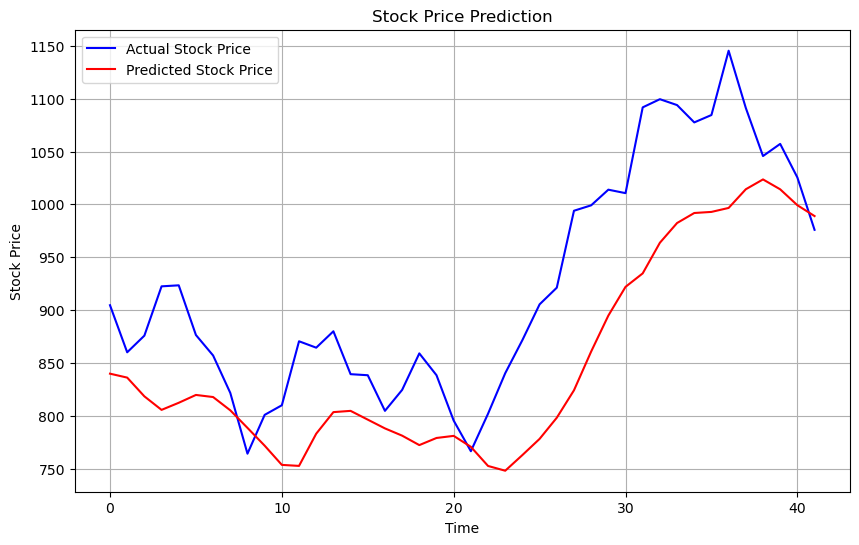

Root Mean Squared Error: 86.39656048109276
Mean Absolute Percentage Error: 0.07805098860924428
Thời gian training mô hình: 24.925968885421753


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")

print('Thời gian training mô hình:',training_time)